# Team Passing Network – Real Madrid vs Liverpool (StatsBomb Open Data)

## Table of Contents
1. [Introduction](#introduction)
2. [Data Acquisition](#data-acquisition)
3. [Data Filtering](#data-filtering)
4. [Deriving Player Positions](#player-positions)
5. [Building the Passing Network](#building-network)
6. [Visualising the Network](#visualising-network)
7. [Interpretation](#interpretation)

<a id="introduction"></a>
## 1. Introduction

This notebook implements **Part 2 – Visualization of a team's passing network**

**Objective**  
Create a passing network for one team in a single match using StatsBomb event data. Each node represents a player and each edge represents the passing connections between players.

**Data source**

- Provider: **Hudl StatsBomb – Open Data**
- `competition_id = 16`
- `season_id = 1`
- `match_id = 18245`
- Match: **Real Madrid vs Liverpool FC**
- Team analysed: **Real Madrid** (value of `team_name` in the code).

We focus on:
- Completed passes only  
- Open-play passes  
- Player positions (GK, RB, CM, …) inferred from StatsBomb `position_id`

### Import necessary libraries

In [6]:
# Import libraries

import pandas as pd
import matplotlib.pyplot as plt
from mplsoccer import Pitch, Sbopen

<a id="data-acquisition"></a>
## 2. Data Acquisition

We use the `Sbopen` parser from the `mplsoccer` library to access:  
- Matches table  
- Event table (including pass events)  

We explicitly select:

- Competition: **UEFA Champions League 2017–18** (`competition_id = 16`)  
- Season: **2017–18** (`season_id = 1`)  
- Match: **Real Madrid vs Liverpool** (`match_id = 18245`)


### 1. Load competitions, matches and event data

In [7]:
# Initialise StatsBomb open-data parser
parser = Sbopen()

# List competitions
df_comp = parser.competition()
df_comp[['competition_id', 'season_id', 'competition_name', 'season_name']].head(20)



,competition_id,season_id,competition_name,season_name
0,9,281,1. Bundesliga,2023/2024
1,9,27,1. Bundesliga,2015/2016
2,1267,107,African Cup of Nations,2023
3,16,4,Champions League,2018/2019
4,16,1,Champions League,2017/2018
5,16,2,Champions League,2016/2017
6,16,27,Champions League,2015/2016
7,16,26,Champions League,2014/2015
8,16,25,Champions League,2013/2014
9,16,24,Champions League,2012/2013


In [11]:

# Select competition / season / match
competition_id = 16     # UCL
season_id = 1           # 2017–18 season
match_id = 18245        # Real Madrid vs Liverpool final

# Load matches table (for title/info)
df_match = parser.match(competition_id, season_id)

# Load event data
df_event, df_related, df_freeze, df_tactics = parser.event(match_id)

df_event.head()

,id,index,period,timestamp,minute,second,possession,duration,match_id,type_id,...,pass_miscommunication,shot_one_on_one,block_offensive,shot_redirect,foul_committed_advantage,foul_won_advantage,pass_goal_assist,foul_committed_card_id,foul_committed_card_name,injury_stoppage_in_chain
0,5eee3ffd-f0c0-4532-868b-4a66cbf20cb8,1,1,00:00:00,0,0,1,0.000000,18245,35,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,eaa65a92-02d3-4375-b2b7-7c2f679a620c,2,1,00:00:00,0,0,1,0.000000,18245,35,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,9c82d2e5-ebba-4825-b7f9-b11b04433ed8,3,1,00:00:00,0,0,1,0.000000,18245,18,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,b791047a-3eea-452f-b3a9-212bd40cd7cb,4,1,00:00:00,0,0,1,0.000000,18245,18,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,25be91a5-a084-42cb-8cc1-a0fe7b0f52f9,5,1,00:00:00.371000,0,0,2,1.735914,18245,30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
lineups = parser.lineup(match_id)
lineups

,player_id,player_name,player_nickname,jersey_number,match_id,team_id,team_name,country_id,country_name
0,3471,Dejan Lovren,Dejan Lovren,6,18245,24,Liverpool,56,Croatia
1,3473,James Philip Milner,James Milner,7,18245,24,Liverpool,68,England
2,3493,Emre Can,Emre Can,23,18245,24,Liverpool,85,Germany
3,3515,Alberto Moreno Pérez,Alberto Moreno,18,18245,24,Liverpool,214,Spain
4,3531,Mohamed Salah,Mohamed Salah,11,18245,24,Liverpool,66,Egypt
5,3532,Jordan Brian Henderson,Jordan Henderson,14,18245,24,Liverpool,68,England
6,3535,Roberto Firmino Barbosa de Oliveira,Roberto Firmino,9,18245,24,Liverpool,31,Brazil
7,3539,Simon Mignolet,Simon Mignolet,22,18245,24,Liverpool,22,Belgium
8,3567,Georginio Wijnaldum,Georginio Wijnaldum,5,18245,24,Liverpool,160,Netherlands
9,3614,Dominic Solanke,Dominic Solanke,29,18245,24,Liverpool,68,England


<a id="data-filtering"></a>
## 3. Data Filtering

We restrict the dataset to:
1. Pass events (`type_name == "Pass"`)
2. Performed by **Real Madrid**
3. Completed passes only (`outcome_name` is null)
4. Open-play passes only (`sub_type_name` is null)

The cell below performs these steps and prints intermediate counts.


In [18]:
# Step 1 – keep only passes
passes = df_event[df_event["type_name"] == "Pass"].copy()
print("Teams in this match:", passes["team_name"].unique())

# Step 2 – select Real Madrid passes
team_name = "Real Madrid"  # explicitly choose team
team_passes = passes[passes["team_name"] == team_name].copy()
print(f"\nTeam passes before filtering (all outcomes & situations): {len(team_passes)}")

# Step 3 – keep only completed, open-play passes
# 3a) completed passes only
team_passes = team_passes[team_passes["outcome_name"].isna()].copy()
print(f"After keeping only completed passes: {len(team_passes)}")

# 3b) remove set pieces (keep open play only), if sub_type_name is available
if "sub_type_name" in team_passes.columns:
    before = len(team_passes)
    team_passes = team_passes[team_passes["sub_type_name"].isna()].copy()
    print(
        f"After removing set pieces (open play only): {len(team_passes)} "
        f"(removed {before - len(team_passes)} passes)"
    )

# Step 4 – sanity checks
print("\nOutcome distribution (should be only Missing value):")
print(team_passes["outcome_name"].value_counts(dropna=False))

if "sub_type_name" in team_passes.columns:
    print("\nSub-type distribution (should be only Missing value):")
    print(team_passes["sub_type_name"].value_counts(dropna=False))

# Inspect team passes
team_passes



Teams in this match: ['Liverpool' 'Real Madrid']

Team passes before filtering (all outcomes & situations): 673
After keeping only completed passes: 596
After removing set pieces (open play only): 524 (removed 72 passes)

Outcome distribution (should be only Missing value):
outcome_name
NaN    524
Name: count, dtype: int64

Sub-type distribution (should be only Missing value):
sub_type_name
NaN    524
Name: count, dtype: int64


,id,index,period,timestamp,minute,second,possession,duration,match_id,type_id,...,pass_miscommunication,shot_one_on_one,block_offensive,shot_redirect,foul_committed_advantage,foul_won_advantage,pass_goal_assist,foul_committed_card_id,foul_committed_card_name,injury_stoppage_in_chain
11,192c9629-1703-40ab-8498-cab869cf0144,12,1,00:00:08.236000,0,8,3,0.793057,18245,30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16,599fb72e-8baf-4d5b-815e-7beb8c54e6af,17,1,00:00:10.701000,0,10,3,0.987721,18245,30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19,bea53e5b-5a58-4771-a8a6-8b385a10354a,20,1,00:00:11.728000,0,11,3,0.969765,18245,30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
46,c505ce03-0f72-4a92-87bc-08bb2becc7cb,47,1,00:00:43.683000,0,43,5,1.093521,18245,30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
49,50de28cc-1395-4083-8bc4-33d0e25c7975,50,1,00:00:46.116000,0,46,5,2.293233,18245,30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3441,f24dc076-4a4e-48b9-8c25-2b944a39e040,3442,2,00:46:47.217000,91,47,161,2.215643,18245,30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3444,55bbd8dd-c359-45dd-bf9a-31903e25b381,3445,2,00:46:50.780000,91,50,161,2.202693,18245,30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3484,d4563365-a17a-447b-a952-67d65e6f30ab,3485,2,00:47:26.627000,92,26,164,0.946791,18245,30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3488,47993851-8f65-4efe-bf6f-c13d59ae63e9,3489,2,00:47:28.345000,92,28,164,1.248044,18245,30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<a id="player-positions"></a>
## 4. Deriving Player Positions

StatsBomb events include `position_id`, which identifies the player’s role during each action.
We map these IDs to standard role abbreviations (GK, RB, CM, ST, etc.) and assign each player the most frequent position they occupied in the match.


In [37]:
# --- Derive player positions (GK, RB, CM etc.) from StatsBomb position_id ---

# Formation lookup table
formation_dict = {
    1: 'GK', 2: 'RB', 3: 'RCB', 4: 'CB', 5: 'LCB', 6: 'LB',
    7: 'RWB', 8: 'LWB', 9: 'RDM', 10: 'CDM', 11: 'LDM',
    12: 'RM', 13: 'RCM', 14: 'CM', 15: 'LCM', 16: 'LM',
    17: 'RW', 18: 'RAM', 19: 'CAM', 20: 'LAM', 21: 'LW',
    22: 'RCF', 23: 'ST', 24: 'LCF', 25: 'SS'
}

# Filter all events from the selected team (not only passes)
team_events = df_event[df_event["team_name"] == team_name].copy()

# Extract each player's most common position_id (convert to int!)
pos_per_player = (
    team_events
    .dropna(subset=["position_id"])
    .groupby("player_name")["position_id"]
    .agg(lambda x: int(x.value_counts().index[0]))
)

# Map to abbreviations using formation_dict
position_abbrev_map = pos_per_player.map(formation_dict)

# Display table
position_abbrev_map.to_frame("position").sort_index()


,position
player_name,
Carlos Henrique Casimiro,CDM
Cristiano Ronaldo dos Santos Aveiro,LCF
Daniel Carvajal Ramos,RB
Francisco Román Alarcón Suárez,CAM
Gareth Frank Bale,RW
José Ignacio Fernández Iglesias,RB
Karim Benzema,RCF
Keylor Navas Gamboa,GK
Luka Modrić,RCM


<a id="building-network"></a>
## 5. Building the Passing Network

We create:
- **Node table**: average (x,y) location and number of passes per player  
- **Link table**: number of completed passes between two players  
- Only edges with ≥ 3 passes are shown to avoid clutter


In [38]:
# Node table: average pass locations per player + number of passes

node_data = (
    team_passes
    .groupby("player_name")
    .agg(
        x=("x", "mean"),
        y=("y", "mean"),
        passes_made=("id", "count")
    )
    .reset_index()
)

# Attach position abbreviation (GK, RB, CM, ...)
node_data["position_abbreviation"] = node_data["player_name"].map(position_abbrev_map)

node_data



,player_name,x,y,passes_made,position_abbreviation
0,Carlos Henrique Casimiro,61.163333,38.320000,30,CDM
1,Cristiano Ronaldo dos Santos Aveiro,79.068966,16.286207,29,LCF
2,Daniel Carvajal Ramos,61.363158,73.626316,19,RB
3,Francisco Román Alarcón Suárez,74.426087,40.584783,46,CAM
4,Gareth Frank Bale,63.657143,67.971429,7,RW
5,José Ignacio Fernández Iglesias,69.094737,70.934211,38,RB
6,Karim Benzema,78.771429,25.802857,35,RCF
7,Keylor Navas Gamboa,14.080000,41.210000,10,GK
8,Luka Modrić,63.092188,57.051563,64,RCM
9,Marcelo Vieira da Silva Júnior,68.324590,10.775410,61,LB


In [39]:
# Print positions of each player (sorted by position, then name)

player_positions_table = (
    node_data[["player_name", "position_abbreviation", "passes_made"]]
    .sort_values(["position_abbreviation", "player_name"])
    .reset_index(drop=True)
)

player_positions_table


,player_name,position_abbreviation,passes_made
0,Francisco Román Alarcón Suárez,CAM,46
1,Carlos Henrique Casimiro,CDM,30
2,Keylor Navas Gamboa,GK,10
3,Marcelo Vieira da Silva Júnior,LB,61
4,Sergio Ramos García,LCB,65
5,Cristiano Ronaldo dos Santos Aveiro,LCF,29
6,Toni Kroos,LCM,72
7,Marco Asensio Willemsen,LW,1
8,Daniel Carvajal Ramos,RB,19
9,José Ignacio Fernández Iglesias,RB,38


In [40]:
# Links: passes between players
links = (
    team_passes[team_passes["pass_recipient_name"].notna()]
    .groupby(["player_name", "pass_recipient_name"])
    .size()
    .reset_index(name="pass_count")
)

min_passes_between = 3
links = links[links["pass_count"] >= min_passes_between].copy()

links.head()


,player_name,pass_recipient_name,pass_count
3,Carlos Henrique Casimiro,José Ignacio Fernández Iglesias,5
5,Carlos Henrique Casimiro,Luka Modrić,3
6,Carlos Henrique Casimiro,Marcelo Vieira da Silva Júnior,3
8,Carlos Henrique Casimiro,Raphaël Varane,5
9,Carlos Henrique Casimiro,Toni Kroos,8


<a id="visualising-network"></a>
## 6. Visualising the Passing Network

- Nodes represent players  
- Node size = number of passes made  
- Edge width = number of passes between players  
- Node label = player’s position (GK, RB, CM, …) or initials as fallback  


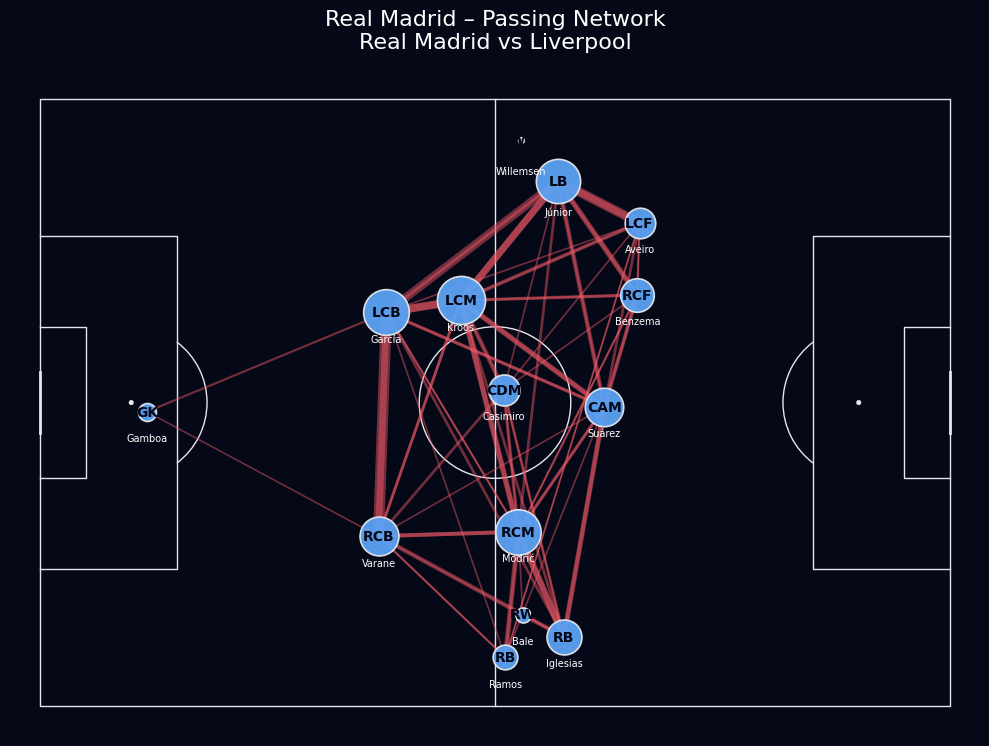

In [41]:
# Create StatsBomb pitch
pitch = Pitch(
    pitch_type='statsbomb',
    pitch_color='#050816',
    line_color='#e5e7eb',
    linewidth=1.0
)

fig, ax = pitch.draw(figsize=(10, 8))
fig.set_facecolor('#050816')

# Positions dict for coordinates
pos = node_data.set_index('player_name')[['x', 'y']].to_dict('index')

# --- Plot edges ---
max_width = 8
max_passes = links['pass_count'].max() if not links.empty else 1

for _, row in links.iterrows():
    passer = row['player_name']
    receiver = row['pass_recipient_name']

    if passer not in pos or receiver not in pos:
        continue

    start = pos[passer]
    end = pos[receiver]
    lw = (row['pass_count'] / max_passes) * max_width

    pitch.lines(
        start['x'], start['y'],
        end['x'], end['y'],
        lw=lw,
        alpha=0.45,
        color="#F45B69",
        zorder=2,
        ax=ax
    )

# --- Plot nodes ---
max_marker_size = 1200
max_passes_made = node_data['passes_made'].max()

for _, row in node_data.iterrows():
    size = (row['passes_made'] / max_passes_made) * max_marker_size

    # Node (circle)
    pitch.scatter(
        row['x'], row['y'],
        s=size,
        color='#5BA2F4',
        edgecolor='#e5e7eb',
        linewidth=1.2,
        alpha=0.95,
        zorder=3,
        ax=ax
    )

    # Center label: position abbreviation if available, otherwise initials
    pos_label = row.get("position_abbreviation")
    if isinstance(pos_label, str) and pos_label.strip():
        center_label = pos_label  # e.g. CM, RB, ST
    else:
        parts = row['player_name'].split()
        first_initial = parts[0][0].upper()
        last_initial = parts[-1][0].upper() if len(parts) > 1 else ""
        center_label = first_initial + last_initial

    ax.text(
        row['x'], row['y'],
        center_label,
        ha='center', va='center',
        color="#050816",
        fontsize=10,
        fontweight='bold',
        zorder=4
    )

    # Player surname label below node
    surname = row['player_name'].split()[-1]
    offset = 4 if row['y'] < 15 else 3.5

    ax.text(
        row['x'], row['y'] + offset,
        surname,
        ha='center', va='center',
        color="white",
        fontsize=7,
        zorder=4
    )

# Title
match_row = df_match[df_match['match_id'] == match_id].iloc[0]
home = match_row['home_team_name']
away = match_row['away_team_name']

title = f"{team_name} – Passing Network"
subtitle = f"{home} vs {away}"

ax.set_title(
    f"{title}\n{subtitle}",
    fontsize=16,
    color="white",
    pad=15
)

plt.tight_layout()
plt.show()


<a id="interpretation"></a>
## 7. Interpretation

The passing network highlights a possession structure in which Real Madrid circulate the ball predominantly through the defensive line and especially the left side. The left centre-back (LCB – Ramos García) is the most influential player in the network, evidenced by the largest node size and several strong passing links to the left-back, central midfielders, and the right centre-back. This indicates that a significant portion of the team’s build-up originated from Ramos García.

The left-back (LB – Marcelo Júnior) also plays a major role in progression, acting as a key outlet and consistently connecting with Kroos (LCM) and the advanced players on his side. Together, García and Júnior form the team’s primary channel for controlled forward movement.

In midfield, Kroos (LCM) and Modrić (RCM) serve as the main connectors, linking the back line to the attacking midfield and forwards. Kroos in particular shows higher involvement in possession circulation, while Casemiro (CDM) displays a smaller node size, indicating a more defensive and stabilising role with fewer distribution responsibilities.

The attacking midfielder (CAM – Suárez) appears mainly as a receiver between lines. His node receives multiple incoming passes but shows fewer outgoing ones, suggesting he operates as an advanced link rather than a dominant distributor. The two forwards (LCF and RCF) have relatively small nodes and limited outgoing passes, consistent with a role focused on receiving progression rather than participating heavily in ball circulation.

Overall, the network reflects a patient, left-oriented build-up pattern where the central defenders and left-back play a decisive role in ball movement, the midfield orchestrates connections selectively, and the forwards primarily act as end-point receivers.

